In [1]:
import numpy as np
import mdp
from ct_ucrl import ct_ucrl, extended_value_iteration
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Test of CT_MDP

In [2]:
n_states = n_actions = 2
p = np.array([[[0, 1],[0, 1]],
     [[1, 0],[1, 0]]])
r = np.array([[5, 8], [-4, -12]])
holding_lambda = np.array([[3, 5], [2, 7]])
ct_mdp = mdp.CTMDP(2, 2, p, r, holding_lambda)
holding_time_record = {0: {0: [], 1:[]}, 1: {0: [], 1:[]}}
transit_record = {0: {0: np.array([0, 0]), 1:np.array([0, 0])}, 
                  1: {0: np.array([0, 0]), 1:np.array([0, 0])}}

In [3]:
print(ct_mdp.reset(0))
for i in range(50000):
    ac = np.random.randint(2)
    state = ct_mdp.state
    next_state, reward, holding_time = ct_mdp.step(ac)
    holding_time_record[state][ac].append(holding_time)
    transit_record[state][ac][next_state] += 1

0


In [4]:
for state in [0, 1]:
    for action in [0, 1]:
        print(state, action, 1/np.mean(holding_time_record[state][action]))
        print(transit_record[state][action]/np.sum(transit_record[state][action]))

0 0 3.006532347357704
[0. 1.]
0 1 5.0196961849632435
[0. 1.]
1 0 1.9658532723197186
[1. 0.]
1 1 7.011244840952338
[1. 0.]


# Test of CT_UCRL

In [5]:
eps = 1e-4
n_actions = 2

# Two-state example
# n_states = 2
# p = np.array([[[0, 1],[0, 1]],
#      [[1, 0],[1, 0]]])
# r = np.array([[5, 8], [-4, -12]])
# holding_lambda = np.array([[3, 5], [2, 7]])

# Three-state example
n_states = 3
p = np.array([[[0, 1/2, 1/2], [0, 1/3, 2/3]],
              [[2/3, 0, 1/3], [1/4, 0, 3/4]],
              [[1/2, 1/2, 0], [3/5, 2/5, 0]]])
r = np.array([[5, 8], [5, 2], [4, 10]])/10
holding_lambda = np.array([[5, 2], [2, 1], [7, 3]])

## Optimal Value Function

In [6]:
state_val, best_ac, best_mdp = extended_value_iteration(
    n_states, n_actions, np.array(r), np.array(p), np.zeros(np.shape(p)[:2]), 
    1 / np.array(holding_lambda), np.zeros(np.shape(holding_lambda)), 
    holding_lambda.min(), holding_lambda.max(), eps)
st = 2
ac = best_ac[st]
rho_star = ((p[st][ac] * state_val).sum() - state_val[st] + r[st, ac]) * holding_lambda[st, ac]
rho_star

1.9449707964090934

## CT-UCRL

In [10]:
opt_tr = {}
num_dec_epoch = 20000000
num_sim = 1
opt_regret = {}
for sim in range(num_sim):
    print(sim, end='\r')
    opt_tr[sim] = []
    opt_regret[sim] = []
    ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)

    transitions = ct_ucrl(ct_mdp, np.max(holding_lambda), np.min(holding_lambda), 
                        r, 0.005, 0)
    sum_reward = 0

    for _ in range(num_dec_epoch):
        (t, st, ac, next_st, holding_time, reward) = transitions.__next__()
        opt_tr[sim].append((t, st, ac, next_st, holding_time, reward))
        sum_reward += reward
        opt_regret[sim].append((rho_star * ct_mdp.timer - sum_reward,
                                rho_star * ct_mdp.timer, sum_reward))

In [ ]:
np_opt_regret = np.array([opt_regret[sim] for sim in range(num_sim)])
np_opt_regret

array([[[1.01617135e+00, 1.81617135e+00, 8.00000000e-01],
        [1.23244653e-01, 1.92324465e+00, 1.80000000e+00],
        [4.97448984e-01, 3.09744898e+00, 2.60000000e+00],
        ...,
        [7.35189470e+04, 2.76723965e+06, 2.69372070e+06],
        [7.35185083e+04, 2.76723971e+06, 2.69372120e+06],
        [7.35188914e+04, 2.76724059e+06, 2.69372170e+06]]])

Text(0, 0.5, 'Regret')

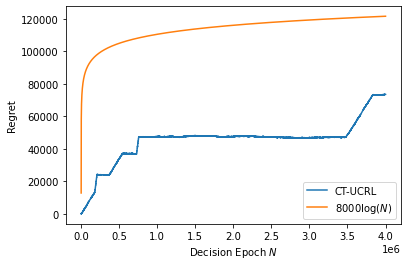

In [ ]:
log_factor = 8000
label_gap = 5
xlabel = [k * label_gap for k in range(1, num_dec_epoch // label_gap + 1)]
plt.plot(xlabel, np_opt_regret.mean(axis=0)[::label_gap, 0], 
         label = 'CT-UCRL')
plt.plot(xlabel, log_factor * np.log(xlabel), 
         label=r'${}\log(N)$'.format(log_factor))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Regret')
# plt.savefig('../../fig/CT-UCRL/EX2/one_path1', bbox_inches='tight', dpi=300)

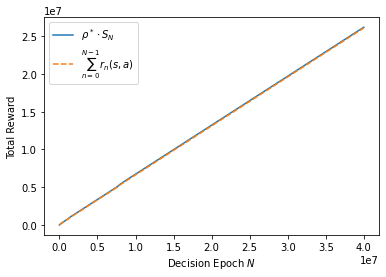

In [138]:
label_gap = 5
xlabel = [k * label_gap for k in range(1, num_dec_epoch // label_gap + 1)]
plt.plot(xlabel, np_opt_regret.mean(axis=0)[::label_gap, 1], 
         label = r'$\rho^* \cdot S_N$')
plt.plot(xlabel, np_opt_regret.mean(axis=0)[::label_gap, 2], 
         label = r'$\sum_{n=0}^{N - 1} r_n(s,a)$', linestyle='--')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Total Reward')
# plt.savefig('../../fig/CT-UCRL/EX2/total_reward1', bbox_inches='tight', dpi=300)

# Sub-optimal Policy

In [108]:
num_dec_epoch = 2000000
ct_mdp = mdp.CTMDP(n_states, n_actions, p, r, holding_lambda)
st = ct_mdp.reset(0)
sub_policy = np.array([0, 0])
sub_tr = []
sub_regret = []
sum_reward = 0
for n in range(num_dec_epoch):
    next_st, reward, holding_time = ct_mdp.step(ac)
    # print('step', t, st, ac, next_st, reward)
    # Update statistics

    st = next_st
    ac = sub_policy[st]
    sub_tr.append((n, ct_mdp.timer, st, ac, next_st, reward))
    sum_reward += reward
    sub_regret.append((rho_star * ct_mdp.timer - sum_reward, 
                       rho_star * ct_mdp.timer, sum_reward))

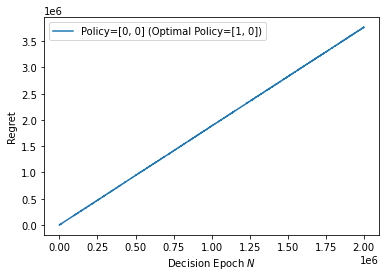

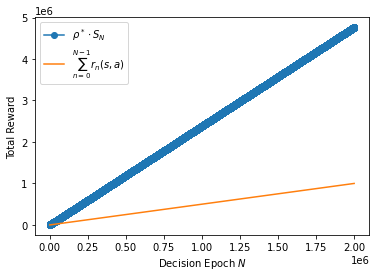

In [111]:
np_sub_regret = np.array(sub_regret)
plt.plot(np_sub_regret[:, 0], label='Policy=[0, 0] (Optimal Policy=[1, 0])')
plt.legend()
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Regret')
plt.show()

plt.plot(np_sub_regret[:, 1], label = r'$\rho^* \cdot S_N$', marker='o')
plt.plot(np_sub_regret[:, 2], label = r'$\sum_{n=0}^{N - 1} r_n(s,a)$')
plt.xlabel(r'Decision Epoch $N$')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

In [89]:
np_sub_tr = np.array(sub_tr)
sub_rho = np_sub_tr[:, -1].sum() / ct_mdp.timer
sub_rho
sub_gap = rho_star - sub_rho
sub_gap

-0.0037547802613753234

In [52]:
bound_const = 34**2 * holding_lambda.max() * 4 * 2 
print(bound_const)
bound_const += 2 * 73**2 * (holding_lambda.max() / holding_lambda.min())**2 * 2 * 2
print(bound_const)
bound_const += 24 * 2 * 2 / (holding_lambda.min()**2)
print(bound_const) 
bound_const *= 3
print(bound_const)

64736
586978.0
587002.0
1761006.0
